#    **Albert Boateng - 20216003**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
url='https://drive.google.com/file/d/1VY0Ux7zIWADd77ZAuFpBbFeGugMmYni-/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
df = pd.read_csv(url).iloc[:,1:3]
df

,text,label_sexist
0,"Damn, this writing was pretty chaotic",not sexist
1,"Yeah, and apparently a bunch of misogynistic v...",not sexist
2,How the FUCK is this woman still an MP!!!???,not sexist
3,Understand. Know you're right. At same time I ...,not sexist
4,Surprized they didn't stop and rape some women,not sexist
...,...,...
13995,complexes like the 'nice chicks' that go after...,sexist
13996,"""GRAPHIC Germany - Muslim ""refugee"" stabbing h...",not sexist
13997,Lol I imagine there would be simps that are li...,not sexist
13998,"It's not, the girls I go on dates with don't k...",not sexist


In [ ]:
df.isna().sum()

text            0
label_sexist    0
dtype: int64

**Text Preprocessing**

In [ ]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   U

True

In [ ]:
text = list(df['text'])
lemmatizer = WordNetLemmatizer()
corpus = []
for i in range(len(text)):
    r = re.sub('[^a-zA-Z]', ' ', text[i])
    r = r.lower()
    r = r.split()
    #r = [word for word in r if word not in stopwords.words('english')]
    r = [lemmatizer.lemmatize(word) for word in r]
    r = ' '.join(r)
    corpus.append(r)
df['text'] = corpus
df

,text,label_sexist
0,damn this writing wa pretty chaotic,not sexist
1,yeah and apparently a bunch of misogynistic vi...,not sexist
2,how the fuck is this woman still an mp,not sexist
3,understand know you re right at same time i kn...,not sexist
4,surprized they didn t stop and rape some woman,not sexist
...,...,...
13995,complex like the nice chick that go after bad ...,sexist
13996,graphic germany muslim refugee stabbing his yo...,not sexist
13997,lol i imagine there would be simps that are li...,not sexist
13998,it s not the girl i go on date with don t kiss...,not sexist


In [ ]:
df.label_sexist.value_counts()

not sexist    10602
sexist         3398
Name: label_sexist, dtype: int64

In [ ]:
dit={}
x=0
for i in df.label_sexist:
    if i not in dit:
        dit[i]=x
        x+=1
df.label_sexist=df.label_sexist.map(dit)
print(dit)

{'not sexist': 0, 'sexist': 1}


In [ ]:
#Over-sampling
from sklearn.utils import resample
p=df[f'{df.columns[-1]}'].value_counts()
df_majority = df[df[f'{df.columns[-1]}']==0]
df_minority = df[df[f'{df.columns[-1]}']==1]
df_minority_upsampled = resample(df_minority,
                                 replace=True,
                                 n_samples=max(p),
                                 random_state=123)
df = pd.concat([df_majority, df_minority_upsampled])
df[f'{df.columns[-1]}'].value_counts()

0    10602
1    10602
Name: label_sexist, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split
X = df.text
y = df.label_sexist

X_remain, X_test, y_remain, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

X_train, X_dev, y_train, y_dev = train_test_split(X_remain, y_remain, test_size=0.1, random_state=50)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
cv = TfidfVectorizer()
X_train = cv.fit_transform(X_train)
X_test = cv.transform(X_test)

X_dev = cv.transform(X_dev)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [ ]:
def make_confusion_matrix(cf_matrix):
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
                        cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [ ]:
X = ['Accuracy','Macro F1-Score']
Y = []
Z = []
A = []
B = []
X_axis = np.arange(len(X))

**Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

In [ ]:
#for dev data

y_dev_pred = clf.predict(X_dev)

clf_dev_accuracy = metrics.accuracy_score(y_dev, y_dev_pred)
clf_dev_f1 = f1_score(y_dev, y_dev_pred, average = "macro")

print("Development Accuracy Store: ",clf_dev_accuracy)
print("Development F1 Score: ",clf_dev_f1)

Development Accuracy Store:  0.8467884502062463
Development F1 Score:  0.846723250042382


label_sexist
Accuracy: 0.8356519688752653
Precision: 0.8249885163068443
Recall: 0.8503787878787878
f1_score: 0.8356309133504047

Classification Report
              precision    recall  f1-score   support

           0       0.85      0.82      0.83      2129
           1       0.82      0.85      0.84      2112

    accuracy                           0.84      4241
   macro avg       0.84      0.84      0.84      4241
weighted avg       0.84      0.84      0.84      4241



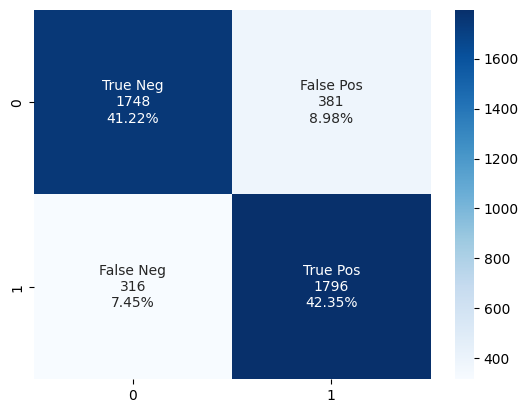

In [ ]:
#Testing
print('label_sexist')
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("f1_score:",metrics.f1_score(y_test, y_pred,average='macro'))
print('\nClassification Report')
print(classification_report(y_test, y_pred))
Y+=[metrics.accuracy_score(y_test, y_pred)]
Y+=[metrics.f1_score(y_test, y_pred,average='macro')]
c1 = confusion_matrix(y_test, y_pred)
make_confusion_matrix(c1)

**Naive Bayes**

In [ ]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

In [ ]:
#for dev data

y_dev_pred = clf.predict(X_dev)

clf_dev_accuracy = metrics.accuracy_score(y_dev, y_dev_pred)
clf_dev_f1 = f1_score(y_dev, y_dev_pred, average = "macro")

print("Development Accuracy Store: ",clf_dev_accuracy)
print("Development F1 Score: ",clf_dev_f1)

Development Accuracy Store:  0.7872716558632882
Development F1 Score:  0.7833610637150461


label_sexist
Accuracy: 0.7818910634284367
Precision: 0.7134124415677814
Recall: 0.9393939393939394
f1_score: 0.7766112329627218

Classification Report
              precision    recall  f1-score   support

           0       0.91      0.63      0.74      2129
           1       0.71      0.94      0.81      2112

    accuracy                           0.78      4241
   macro avg       0.81      0.78      0.78      4241
weighted avg       0.81      0.78      0.78      4241



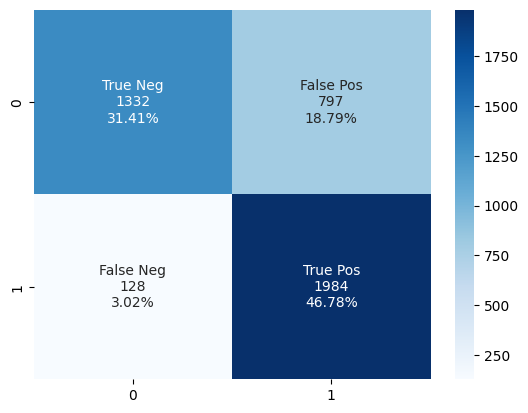

In [ ]:
#Testing
print('label_sexist')
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("f1_score:",metrics.f1_score(y_test, y_pred,average='macro'))
print('\nClassification Report')
print(classification_report(y_test, y_pred))
Z+=[metrics.accuracy_score(y_test, y_pred)]
Z+=[metrics.f1_score(y_test, y_pred,average='macro')]
c1 = confusion_matrix(y_test, y_pred)
make_confusion_matrix(c1)

**AdaBoost**

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(n_estimators=50,learning_rate=1)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

In [ ]:
#for dev data

y_dev_pred = clf.predict(X_dev)

clf_dev_accuracy = metrics.accuracy_score(y_dev, y_dev_pred)
clf_dev_f1 = f1_score(y_dev, y_dev_pred, average = "macro")

print("Development Accuracy Store: ",clf_dev_accuracy)
print("Development F1 Score: ",clf_dev_f1)

Development Accuracy Store:  0.7542722451384797
Development F1 Score:  0.751721706181091


label_sexist
Accuracy: 0.7599622730488093
Precision: 0.8049052396878483
Recall: 0.6837121212121212
f1_score: 0.7584551425277233

Classification Report
              precision    recall  f1-score   support

           0       0.73      0.84      0.78      2129
           1       0.80      0.68      0.74      2112

    accuracy                           0.76      4241
   macro avg       0.77      0.76      0.76      4241
weighted avg       0.77      0.76      0.76      4241



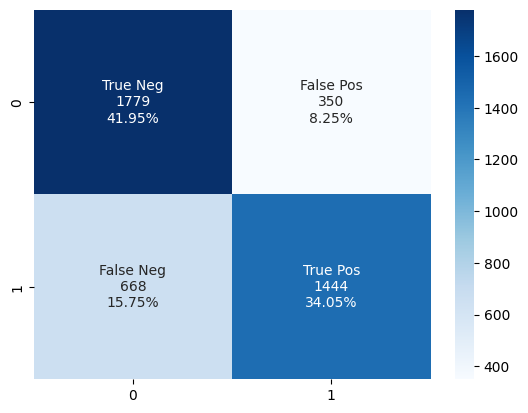

In [ ]:
#Testing
print('label_sexist')
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("f1_score:",metrics.f1_score(y_test, y_pred,average='macro'))
print('\nClassification Report')
A+=[metrics.accuracy_score(y_test, y_pred)]
A+=[metrics.f1_score(y_test, y_pred,average='macro')]
print(classification_report(y_test, y_pred))
c1 = confusion_matrix(y_test, y_pred)
make_confusion_matrix(c1)

**SVM**

In [ ]:
from sklearn import svm
clf = svm.SVC(kernel='linear')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

In [ ]:
#for dev data

y_dev_pred = clf.predict(X_dev)

clf_dev_accuracy = metrics.accuracy_score(y_dev, y_dev_pred)
clf_dev_f1 = f1_score(y_dev, y_dev_pred, average = "macro")

print("Development Accuracy Store: ",clf_dev_accuracy)
print("Development F1 Score: ",clf_dev_f1)

Development Accuracy Store:  0.869180907483795
Development F1 Score:  0.8691754106694892


label_sexist
Accuracy: 0.8597029002593728
Precision: 0.8310781318201659
Recall: 0.9015151515151515
f1_score: 0.8594978896523391

Classification Report
              precision    recall  f1-score   support

           0       0.89      0.82      0.85      2129
           1       0.83      0.90      0.86      2112

    accuracy                           0.86      4241
   macro avg       0.86      0.86      0.86      4241
weighted avg       0.86      0.86      0.86      4241



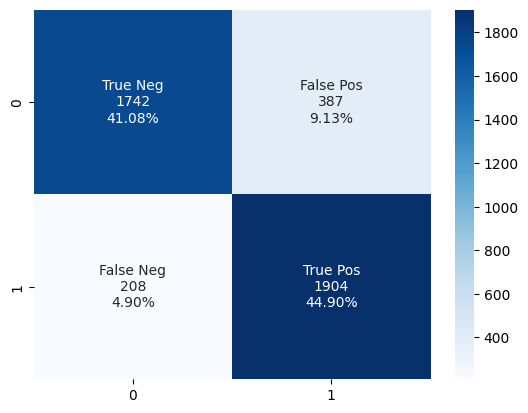

In [ ]:
#Testing
print('label_sexist')
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("f1_score:",metrics.f1_score(y_test, y_pred,average='macro'))
print('\nClassification Report')
print(classification_report(y_test, y_pred))
B+=[metrics.accuracy_score(y_test, y_pred)]
B+=[metrics.f1_score(y_test, y_pred,average='macro')]
c1 = confusion_matrix(y_test, y_pred)
make_confusion_matrix(c1)

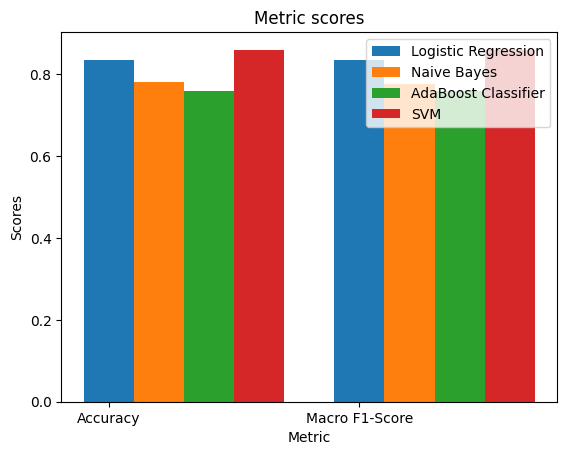

In [ ]:
plt.bar(X_axis, Y, 0.2, label = 'Logistic Regression')
plt.bar(X_axis+0.2 , Z, 0.2, label = 'Naive Bayes')
plt.bar(X_axis + 0.4, A, 0.2, label = 'AdaBoost Classifier')
plt.bar(X_axis + 0.6, B, 0.2, label = 'SVM')

plt.xticks(X_axis, X)
plt.xlabel("Metric")
plt.ylabel("Scores")
plt.title("Metric scores")
plt.legend()
plt.show()